In [1]:
# ================================
# HÜCRE 1 – KÜTÜPHANELERİ YÜKLE
# Bu hücrede çalışmada kullanılacak tüm Python kütüphaneleri içe aktarılır.
# Ayrıca gereksiz uyarılar kapatılır.
# ================================

import warnings
warnings.filterwarnings('ignore')

# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn bileşenleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    precision_recall_fscore_support
)
from scipy.sparse import hstack
from xgboost import XGBClassifier

# PyTorch bileşenleri (MLP ve LSTM için)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


In [2]:
# ==============================================
# HÜCRE 2 – VERİYİ YÜKLE, TEMİZLE VE HEDEFİ OLUŞTUR
# Bu hücre:
# 1) CSV dosyasını okur
# 2) Başlığı (title) boş olan satırları siler
# 3) is_hourly sütununu 0 (Fixed) ve 1 (Hourly) olarak dönüştürür
# ==============================================

csv_path = "all_upwork_jobs_2024-02-07-2024-03-24.csv"

# CSV dosyasını oku
df = pd.read_csv(csv_path, low_memory=False)

# Başlığı (title) boş olan satırları at
df = df.dropna(subset=["title"]).copy()

# is_hourly sütununu 0/1'e çeviren fonksiyon
def map_hourly(v):
    s = str(v).strip().lower()
    if s in ["1", "true", "yes", "y", "hourly"]:
        return 1
    if s in ["0", "false", "no", "n", "fixed"]:
        return 0
    return np.nan

df["is_hourly"] = df["is_hourly"].apply(map_hourly)
df = df.dropna(subset=["is_hourly"]).copy()
df["is_hourly"] = df["is_hourly"].astype(int)

y = df["is_hourly"]

print("Veri boyutu:", df.shape)
print("Sınıf dağılımı:")
print(y.value_counts())

Veri boyutu: (244827, 8)
Sınıf dağılımı:
is_hourly
1    140936
0    103891
Name: count, dtype: int64


In [3]:
# ===================================================
# HÜCRE 3 – ÖZELLİK OLUŞTURMA VE TRAIN/TEST AYIRIMI
# Bu hücre:
# 1) Metin ve sayısal özellikler üretir
# 2) TF-IDF ile başlıklardan kelime temelli özellik çıkarır
# 3) Tüm özellikleri birleştirip train/test olarak böler
# ===================================================

# Metin temelli basit özellikler
df["title_length"] = df["title"].astype(str).str.len()
df["word_count"]  = df["title"].astype(str).str.split().str.len()

# Bütçe ve saatlik ücretle ilgili bayraklar
df["has_budget"] = df["budget"].notna().astype(int)
df["has_hourly"] = df["hourly_low"].notna().astype(int)

# Saatlik ücret ortalaması ve bütçe
df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1).fillna(0)
df["budget_filled"] = df["budget"].fillna(0)

# En sık görülen 10 ülkeyi bırak, diğerlerini "Other" yap
top_countries = df["country"].value_counts().head(10).index.tolist()
df["country_grouped"] = df["country"].apply(
    lambda x: x if x in top_countries else "Other"
).fillna("Unknown")

# Ülke isimlerini sayıya çevir
le_country = LabelEncoder()
df["country_encoded"] = le_country.fit_transform(df["country_grouped"])

# TF-IDF ile başlık metninden kelime özellikleri çıkar
tfidf = TfidfVectorizer(max_features=1000, stop_words="english")
X_text = tfidf.fit_transform(df["title"].astype(str))

# Sayısal özellik sütunları
num_cols = [
    "title_length", "word_count", "has_budget",
    "has_hourly", "country_encoded", "avg_hourly", "budget_filled"
]
X_num = df[num_cols].values

# Metin (seyrek) ve sayısal özellikleri birleştir
X = hstack([X_text, X_num])

# Train/Test ayırımı (sınıf dağılımını koruyarak)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Toplam özellik sayısı:", X.shape[1])
print("Train örnek sayısı:", X_train.shape[0])
print("Test örnek sayısı:",  X_test.shape[0])

Toplam özellik sayısı: 1007
Train örnek sayısı: 195861
Test örnek sayısı: 48966


In [17]:
# ============================================================
# HÜCRE 4 – SKLEARN MODELLERİ (LOGISTIC REGRESSION + XGBOOST)
# Bu hücre:
# 1) Logistic Regression
# 2) XGBoost
# modellerini TEK parametre kombinasyonu ile eğitir.
# Amaç: SVM'yi çıkararak eğitimi hızlandırmak.
# ============================================================

print('\n' + '='*70)
print('SKLEARN MODELLERİ (HIZLI – LR + XGB)')
print('='*70)

sklearn_results = []

# ----------------------------
# 1) Logistic Regression
# ----------------------------
print('\n1) Logistic Regression (tek kombinasyon)...')

# Basit ve hızlı lojistik regresyon modeli
lr = LogisticRegression(
    random_state=42,
    C=1.0,
    solver='liblinear',
    max_iter=300
    # n_jobs parametresini kullanmıyoruz; tek çekirdekte çalışacak
)

# Modeli eğit
lr.fit(X_train, y_train)

# Test setinde tahmin yap
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Sonuçları kaydet
sklearn_results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1': f1_score(y_test, y_pred_lr),
    'AUC': roc_auc_score(y_test, y_prob_lr)
})

# ----------------------------
# 2) XGBoost
# ----------------------------
print('\n2) XGBoost (tek kombinasyon)...')

# Tek kombinasyonlu XGBoost modeli (daha az ağaç, tek derinlik)
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',  # uyarı mesajlarını bastırmak için
    n_estimators=80,        # ağaç sayısı
    max_depth=5,            # ağaç derinliği
    learning_rate=0.1       # öğrenme oranı
    # n_jobs parametresini kullanmıyoruz; CPU'yu kilitlemesin diye
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

sklearn_results.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1': f1_score(y_test, y_pred_xgb),
    'AUC': roc_auc_score(y_test, y_prob_xgb)
})

# ----------------------------
# Sonuçları tabloya dök ve kaydet
# ----------------------------
sklearn_df = pd.DataFrame(sklearn_results).round(4)
print('\nSKLEARN PERFORMANSI (OSAMA)')
print(sklearn_df)

sklearn_df.to_csv('osama_sklearn_models_fast.csv', index=False)
print('\nosama_sklearn_models_fast.csv dosyası kaydedildi')



SKLEARN MODELLERİ (HIZLI – LR + XGB)

1) Logistic Regression (tek kombinasyon)...

2) XGBoost (tek kombinasyon)...

SKLEARN PERFORMANSI (OSAMA)
                 Model  Accuracy  Precision  Recall   F1  AUC
0  Logistic Regression       1.0     0.9999     1.0  1.0  1.0
1              XGBoost       1.0     1.0000     1.0  1.0  1.0

osama_sklearn_models_fast.csv dosyası kaydedildi


In [4]:
# ======================================================
# HÜCRE 5 – PYTORCH İÇİN VERİ HAZIRLAMA
# Bu hücre:
# 1) Seyrek (sparse) X_train ve X_test matrislerini dense hale getirir
# 2) StandardScaler ile ölçekler
# 3) PyTorch DataLoader nesnesi oluşturur
# ======================================================


print("\n" + "="*70)
print("PYTORCH")
print("="*70)

# Seyrek matrisleri yoğun (dense) numpy dizisine çevir
X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense  = X_test.toarray().astype(np.float32)

# Hedef değişkeni numpy dizisine çevir
y_train_np = y_train.values.astype(np.float32)
y_test_np  = y_test.values.astype(np.float32)

# Özellikleri ölçekle (0 ortalama, 1 standart sapma)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled  = scaler.transform(X_test_dense)

# Cihaz seçimi (GPU varsa CUDA, yoksa CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# PyTorch Dataset ve DataLoader
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train_np.reshape(-1, 1))
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,   # her iterasyonda 64 örnek
    shuffle=True
)

# Sonuçları saklamak için liste
pytorch_results = []

# Ortak kayıp fonksiyonu (Binary Cross Entropy)
loss_fn = nn.BCELoss()


PYTORCH
Kullanılan cihaz: cpu


In [5]:
# ======================================================
# HÜCRE 6 – MLP MODELİNİ EĞİT
# Bu hücre:
# 1) Basit bir MLP (tam bağlantılı ağ) tanımlar
# 2) 5 epoch boyunca eğitir (20 yerine 5, hız için)
# 3) Test seti üzerinde tahmin yapar ve metrikleri hesaplar
# ======================================================

print("\n1) MLP modeli eğitiliyor (5 epoch)...")

class MLP(nn.Module):
    """
    Basit çok katmanlı algılayıcı (Multi Layer Perceptron) modeli.
    Giriş: TF-IDF + sayısal özellikler
    Çıkış: 0-1 arası olasılık (Hourly olma olasılığı)
    """
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1   = nn.Linear(input_size, 128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2   = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3   = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

mlp_model = MLP(X_train_scaled.shape[1]).to(device)
optim_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_model.train()
for epoch in range(5):   # 5 epoch
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_mlp.zero_grad()
        out  = mlp_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_mlp.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp: {epoch_loss/len(train_loader):.4f}")

# Test seti üzerinde değerlendirme
mlp_model.eval()
with torch.no_grad():
    y_prob_mlp = mlp_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()
    y_pred_mlp = (y_prob_mlp > 0.5).astype(int)

pytorch_results.append({
    "Model": "MLP",
    "Architecture": "128-64-1",
    "Accuracy":  accuracy_score(y_test_np, y_pred_mlp),
    "Precision": precision_score(y_test_np, y_pred_mlp),
    "Recall":    recall_score(y_test_np, y_pred_mlp),
    "F1":        f1_score(y_test_np, y_pred_mlp),
    "AUC":       roc_auc_score(y_test_np, y_prob_mlp)
})



1) MLP modeli eğitiliyor (5 epoch)...
Epoch 1/5 - Ortalama Kayıp: 0.0286
Epoch 2/5 - Ortalama Kayıp: 0.0007
Epoch 3/5 - Ortalama Kayıp: 0.0008
Epoch 4/5 - Ortalama Kayıp: 0.0003
Epoch 5/5 - Ortalama Kayıp: 0.0001


In [7]:
# ======================================================
# HÜCRE 7 – LSTM MODELİNİ EĞİT
# Bu hücre:
# 1) LSTM tabanlı bir model tanımlar
# 2) 5 epoch boyunca eğitir
# 3) Test seti üzerinde tahmin yapar ve metrikleri hesaplar
# Not: Aslında verimiz zamansal değil, fakat ödev kapsamında LSTM deneniyor.
# ======================================================

print("\n2) LSTM modeli eğitiliyor (5 epoch)...")

class LSTMModel(nn.Module):
    """
    LSTM tabanlı model.
    Giriş: (batch_size, features) -> (batch_size, 1, features)
    """
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            batch_first=True,
            num_layers=1
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)             # (batch, features) -> (batch, 1, features)
        _, (h, _) = self.lstm(x)
        x = self.fc(h[-1])
        return x

lstm_model = LSTMModel(X_train_scaled.shape[1]).to(device)
optim_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

lstm_model.train()
for epoch in range(5):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optim_lstm.zero_grad()
        out  = lstm_model(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        optim_lstm.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/5 - Ortalama Kayıp: {epoch_loss/len(train_loader):.4f}")

# Test seti değerlendirme
lstm_model.eval()
with torch.no_grad():
    y_prob_lstm = lstm_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy().flatten()
    y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

pytorch_results.append({
    "Model": "LSTM",
    "Architecture": "LSTM(64)-32-1",
    "Accuracy":  accuracy_score(y_test_np, y_pred_lstm),
    "Precision": precision_score(y_test_np, y_pred_lstm),
    "Recall":    recall_score(y_test_np, y_pred_lstm),
    "F1":        f1_score(y_test_np, y_pred_lstm),
    "AUC":       roc_auc_score(y_test_np, y_prob_lstm)
})

pytorch_df = pd.DataFrame(pytorch_results).round(4)
print("\nPYTORCH PERFORMANSI (OSAMA)")
print(pytorch_df)

pytorch_df.to_csv("osama_pytorch_models_fast.csv", index=False)
print("\nosama_pytorch_models_fast.csv dosyası kaydedildi.")



2) LSTM modeli eğitiliyor (5 epoch)...
Epoch 1/5 - Ortalama Kayıp: 0.0621
Epoch 2/5 - Ortalama Kayıp: 0.0002
Epoch 3/5 - Ortalama Kayıp: 0.0001
Epoch 4/5 - Ortalama Kayıp: 0.0000
Epoch 5/5 - Ortalama Kayıp: 0.0000

PYTORCH PERFORMANSI (OSAMA)
  Model   Architecture  Accuracy  Precision  Recall      F1  AUC
0   MLP       128-64-1    1.0000        1.0  1.0000  1.0000  1.0
1  LSTM  LSTM(64)-32-1    0.9999        1.0  0.9999  0.9999  1.0

osama_pytorch_models_fast.csv dosyası kaydedildi.


In [15]:
# ======================================================
# HÜCRE 8 – SINIF BAZLI METRİKLERİ HESAPLA
# Bu hücre:
# Her model için 0 ve 1 sınıfları bazında Precision, Recall ve F1-Score hesaplar.
# Sonuçları CSV dosyasına yazar.
# ======================================================
class_results = []

for y_pred, name in [
    (y_pred_mlp,  "MLP"),
    (y_pred_lstm, "LSTM"),
]:
    prec, rec, f1, sup = precision_recall_fscore_support(
        y_test_np, y_pred, average=None, zero_division=0
    )
    for i in [0, 1]:
        class_results.append({
            "Model": name,
            "Sinif": str(i),
            "Precision": round(prec[i], 4),
            "Recall":    round(rec[i], 4),
            "F1":        round(f1[i], 4)
        })

class_df = pd.DataFrame(class_results)
print(class_df.to_string(index=False))
class_df.to_csv("osama_class_wise_metrics_fast.csv", index=False)
print("osama_class_wise_metrics_fast.csv dosyası kaydedildi")

Model Sinif  Precision  Recall     F1
  MLP     0     1.0000  1.0000 1.0000
  MLP     1     1.0000  1.0000 1.0000
 LSTM     0     0.9999  1.0000 0.9999
 LSTM     1     1.0000  0.9999 0.9999
osama_class_wise_metrics_fast.csv dosyası kaydedildi


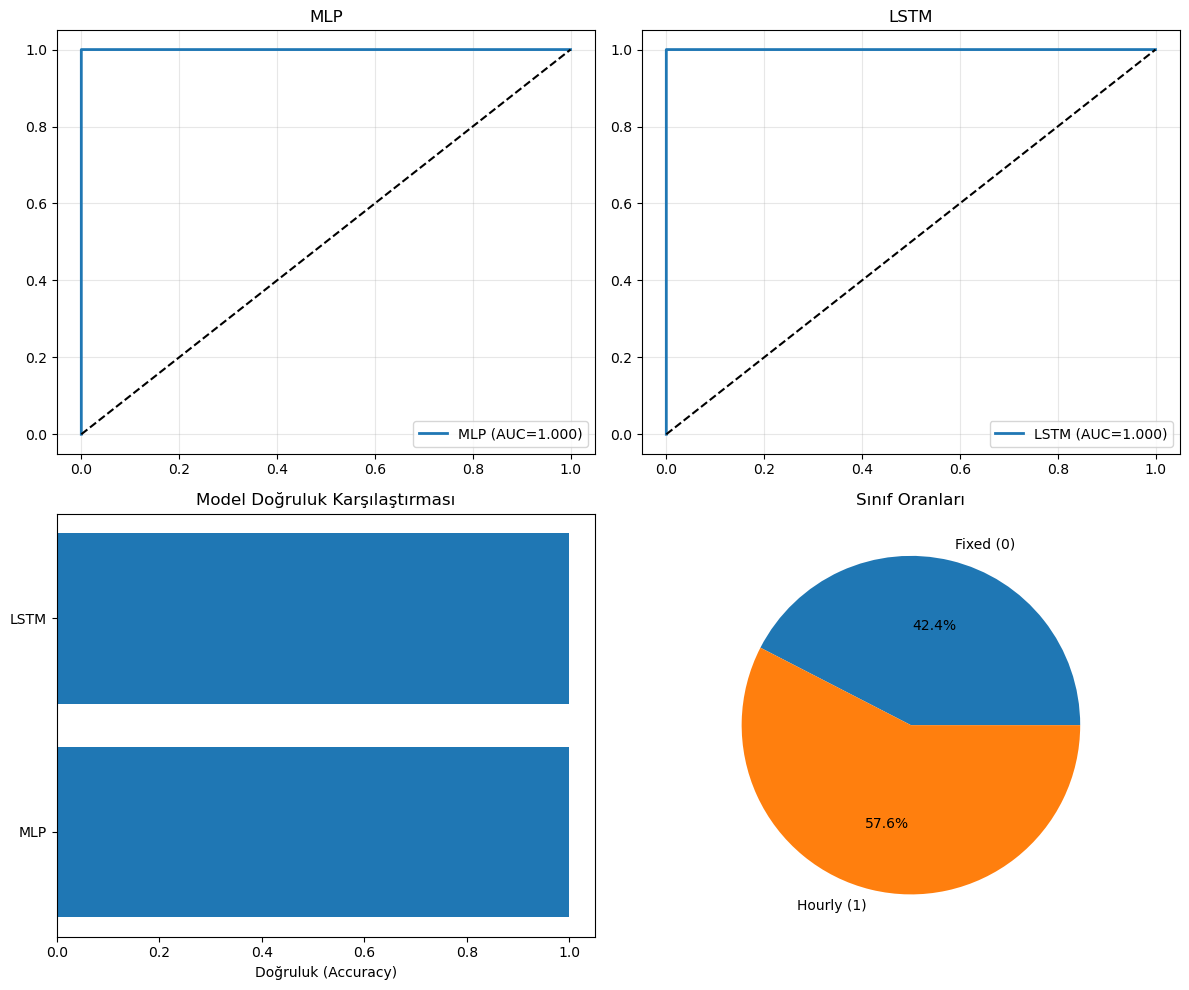

In [21]:
# ======================================================
# HÜCRE 9 – ROC EĞRİLERİ VE SINIF DAĞILIMI GÖRSELLERİ
# Bu hücre:
# 1) Her model için ROC eğrilerini tek figürde çizer
# 2) Modellerin doğruluklarını bar grafik olarak gösterir
# 3) Hedef değişkenin sınıf dağılımını pie ve histogram ile gösterir
# ======================================================

# ROC eğrileri ve doğruluk karşılaştırması
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ROC eğrileri
for y_proba, label, ax in [
    (y_prob_mlp,  "MLP",  axes[0, 0]),
    (y_prob_lstm, "LSTM", axes[0, 1]),
]:
    fpr, tpr, _ = roc_curve(y_test_np, y_proba)
    auc = roc_auc_score(y_test_np, y_proba)
    ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})", linewidth=2)
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_title(label)
    ax.legend()
    ax.grid(alpha=0.3)

# Doğruluk bar grafiği
ax = axes[1, 0]
ax.barh(
    ["MLP", "LSTM"],
    [
        accuracy_score(y_test_np, y_pred_mlp),
        accuracy_score(y_test_np, y_pred_lstm),
    ]
)
ax.set_xlabel("Doğruluk (Accuracy)")
ax.set_title("Model Doğruluk Karşılaştırması")

# Sınıf dağılımı (pie)
sizes = pd.Series(y).value_counts().sort_index()
ax = axes[1, 1]
ax.pie(
    sizes,
    labels=["Fixed (0)", "Hourly (1)"],
    autopct="%1.1f%%"
)
ax.set_title("Sınıf Oranları")

plt.tight_layout()
plt.savefig("osama_roc_curves_comparison_fast.png", dpi=200, bbox_inches="tight")
plt.show()


